In [1]:
import glob
import json
import os
from collections import defaultdict
from multiprocessing import Pool

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import cm
from rdkit import Chem
from rdkit.Chem import QED, Descriptors, Lipinski
from rdkit.Contrib.SA_Score import sascorer

In [2]:
runs_base = "../runs/"

limit_name = "samples"

# find all config files
config_pattern = os.path.join(runs_base, f"best_variance_{limit_name}/*/config.json")
config_fnames = glob.glob(config_pattern)

# add virtual screening config files
vs_pattern = "../runs/virtual_screening/*/config.json"
vs_config_fnames = glob.glob(vs_pattern)
config_fnames.extend(vs_config_fnames)

sampled_smiles = defaultdict(list)

for config_fname in config_fnames:
    with open(config_fname, "r") as f:
        config = json.load(f)
    opt_name = config["optimizer_name"]
    if opt_name == "VS":
        suffix = "MaxMin" if "maxmin" in config["optimizer_args"]["smiles_file"] else "Random"
        opt_name = f"VS_{suffix}"

    results_fname = config_fname.replace("config.json", f"results_diverse_all_{limit_name}.csv")
    if os.path.exists(results_fname):
        results = pd.read_csv(results_fname)
    else:
        print("No results file found for", config_fname)
        continue

    results["CanSmiles"].to_list()

    sampled_smiles[f"{opt_name}"].append(results["CanSmiles"].to_list())


# Convert the dictionary to a list of dictionaries
rows = []
for method, folds in sampled_smiles.items():
    # if method.startswith('VS'): continue
    for fold_num, smiles_list in enumerate(folds, start=1):
        for smiles in smiles_list:
            rows.append({"Method": method, "Replica": fold_num, "SMILES": smiles})

# Create DataFrame
df = pd.DataFrame(rows)
df.head()

No results file found for ../runs/best_variance_samples/GSK3_LSTM-PPO_12_1/config.json


,Method,Replica,SMILES
0,AugMemory,1,O=C1c2ccccc2S(=O)(=O)N1CCCCN1CCN(c2ccccc2)CC1
1,AugMemory,1,c1cc(N2CCN(CCCCc3c[nH]c4ccc(-n5cnnc5)cc34)CC2)...
2,AugMemory,1,O=C(CCCN1CCCC(CC2CCCCCC2)C1)c1ccc(F)cc1
3,AugMemory,1,Clc1cccc(N2CCN(CCCCC3CCC(CN4CCn5c(nc6ccc(Cl)cc...
4,AugMemory,1,Oc1cc2cc(CCCN(O)CCCCCCN3CCN(c4ccc(F)cc4)CC3)cc...


In [3]:
# Function to compute molecular descriptors
def compute_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Compute descriptors
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)  # type: ignore
        qed = QED.qed(mol)
        sas = sascorer.calculateScore(mol)

        # Additional descriptors
        hba = Lipinski.NumHAcceptors(mol)
        hbd = Lipinski.NumHDonors(mol)

        # Lipinski Rule of Five
        ro5 = all(
            [
                Descriptors.MolWt(mol) <= 500,
                Descriptors.MolLogP(mol) <= 5,  # type: ignore
                Lipinski.NumHAcceptors(mol) <= 10,
                Lipinski.NumHDonors(mol) <= 5,
            ]
        )

        return mw, logp, qed, hba, hbd, sas, ro5
    else:
        return None


with Pool(12) as p:
    df[["MW", "logP", "QED", "HBA", "HBD", "SAS", "RO5"]] = p.map(compute_molecular_descriptors, df["SMILES"].to_list())

# Drop rows where descriptors couldn't be computed
print(df.isna().sum())
df = df.dropna(subset=["MW", "logP", "QED", "HBA", "HBD", "SAS", "RO5"])

Method     0
Replica    0
SMILES     0
MW         0
logP       0
QED        0
HBA        0
HBD        0
SAS        0
RO5        0
dtype: int64


In [4]:
# For each method find the SMILES with the highest, lowest and median QED
import pandas as pd

quantile_smiles = []
for method in df["Method"].unique():
    df_ = df[(df.Method == method)]
    idx_min = df_.QED.idxmin()
    idx_max = df_.QED.idxmax()

    smi_min = df_.loc[idx_min, "SMILES"]
    qed_min = df_.loc[idx_min, "QED"]
    SAS_min = df_.loc[idx_min, "SAS"]

    smi_max = df_.loc[idx_max, "SMILES"]
    qed_max = df_.loc[idx_max, "QED"]
    SAS_max = df_.loc[idx_max, "SAS"]

    qed_med = df_.QED.median()
    idx_med = df_[df_.QED >= qed_med].QED.idxmin()
    smi_med = df_.loc[idx_med, "SMILES"]
    SAS_med = df_.loc[idx_med, "SAS"]

    d = pd.DataFrame(
        {
            "Method": method,
            "Type": ["min", "med", "max"],
            "SMILES": [smi_min, smi_med, smi_max],
            "QED": [qed_min, qed_med, qed_max],
            "SAS": [SAS_min, SAS_med, SAS_max],
        }
    )
    quantile_smiles.append(d)

df_smiles = pd.concat(quantile_smiles, ignore_index=True)

In [5]:
# Draw the median molecules
from rdkit.Chem import Draw

# Select methods to plot and get median qed molecules
plot_methods = ["AugMemory", "LSTM-PPO", "Mars", "VS_Random"]
df_sub = df_smiles[(df_smiles.Method.isin(plot_methods)) & (df_smiles.Type == "med")].copy()
df_sub.sort_values("Method", key=lambda x: x.map({method: i for i, method in enumerate(plot_methods)}), inplace=True)
plot_smiles = df_sub.SMILES.to_list()

# Add some annotations
legends = "QED: " + df_sub.QED.round(2).astype(str) + ", SAS: " + df_sub.SAS.round(2).astype(str)
legends = legends.to_list()
print(legends)

['QED: 0.22, SAS: 3.26', 'QED: 0.47, SAS: 2.38', 'QED: 0.1, SAS: 4.48', 'QED: 0.5, SAS: 2.22']


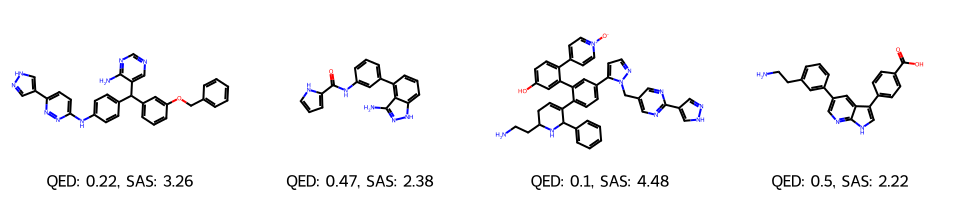

In [6]:
# Actually draw the molecules
plot_mols = [Chem.MolFromSmiles(smi) for smi in plot_smiles]
draw = Draw.MolsToGridImage(plot_mols, molsPerRow=4, subImgSize=(240, 200), legends=legends, useSVG=True)

# save svg;
with open("figures/molplots.svg", "w") as f:
    f.write(draw.data)
display(draw)

/tmp/ipykernel_18839/2213696842.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


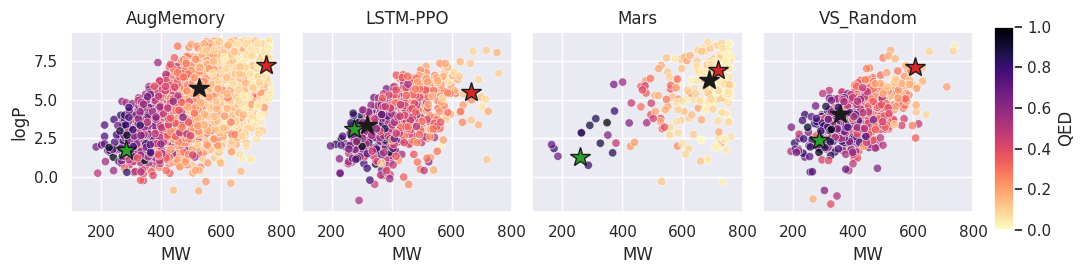

In [7]:
# Set the style of seaborn
x = "MW"
y = "logP"
num_rows = 1
num_cols = 4

sns.set_theme(style="darkgrid")

# Create a figure and subplots
fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=(num_cols * 2.5, num_rows * 2.9),
    sharey=True,
    sharex=True,
)

# Loop through each method and plot on a subplot
methods = df["Method"].unique()
for i, method in enumerate(plot_methods):
    ax = axes[i]
    # Filter DataFrame for the current method
    method_df = df[df["Method"] == method]

    # Create a scatter plot on the current subplot
    # sns.scatterplot(x=x, y=y, data=method_df, ax=ax, hue='RO5', palette=['r', 'b'], alpha=0.75)
    scatter = sns.scatterplot(
        x=x, y=y, data=method_df, ax=ax, hue="QED", legend=False, palette="magma_r", alpha=0.75, rasterized=True
    )

    # Min, Median, Max QED
    mw_min, log_min = method_df.loc[method_df.QED.idxmin(), "MW"], method_df.loc[method_df.QED.idxmin(), "logP"]
    mw_max, log_max = method_df.loc[method_df.QED.idxmax(), "MW"], method_df.loc[method_df.QED.idxmax(), "logP"]
    qed_med = method_df[method_df.QED >= method_df.QED.median()].QED.min()

    mw_med = method_df.loc[method_df.QED == qed_med, "MW"].values[0]  # type: ignore
    log_med = method_df.loc[method_df.QED == qed_med, "logP"].values[0]  # type: ignore

    kwargs = dict(marker="*", ms=15, mec="k")
    ax.plot(mw_min, log_min, mfc="tab:red", **kwargs)
    ax.plot(mw_med, log_med, mfc="k", **kwargs)
    ax.plot(mw_max, log_max, mfc="tab:green", **kwargs)

    # Set subplot title
    ax.set_title(method)

    # Set subplot labels
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    ax.set_aspect("auto", adjustable="datalim")

axes[0].set_xlim(100, 800)
# axes[0].set_ylim(-3, 13)

# Add colorbar to the last subplot
cbar_ax = fig.add_axes([1, 0.18, 0.02, 0.7])  # Adjust these values as needed
# cbar = plt.colorbar(scatter.get_children()[0], cax=cbar_ax, )  # Use the first element of the scatter plot's children
cbar = plt.colorbar(
    cm.ScalarMappable(cmap="magma_r"),
    cax=cbar_ax,
)  # Use the first element of the scatter plot's children
# Add label to the colorbar
cbar.set_label("QED")

# reduce vspace
plt.subplots_adjust(hspace=-0.3)
fig.tight_layout()

# save as pdf but scatter plot is save as png
plt.savefig("figures/PCA_MW_logP.svg", dpi=300, bbox_inches="tight")